<a href="https://colab.research.google.com/github/akinyeleolat/facial-expression-classification/blob/main/face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Set **up**

In [1]:
import os
os.environ['KAGGLE_USERNAME']='oluwatosinaakinyele'
os.environ['KAGGLE_KEY']='****'

In [2]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 88% 106M/121M [00:01<00:00, 80.2MB/s] 
100% 121M/121M [00:01<00:00, 90.7MB/s]


In [3]:
#upload data
from zipfile import ZipFile
file_name ="/content/face-expression-recognition-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


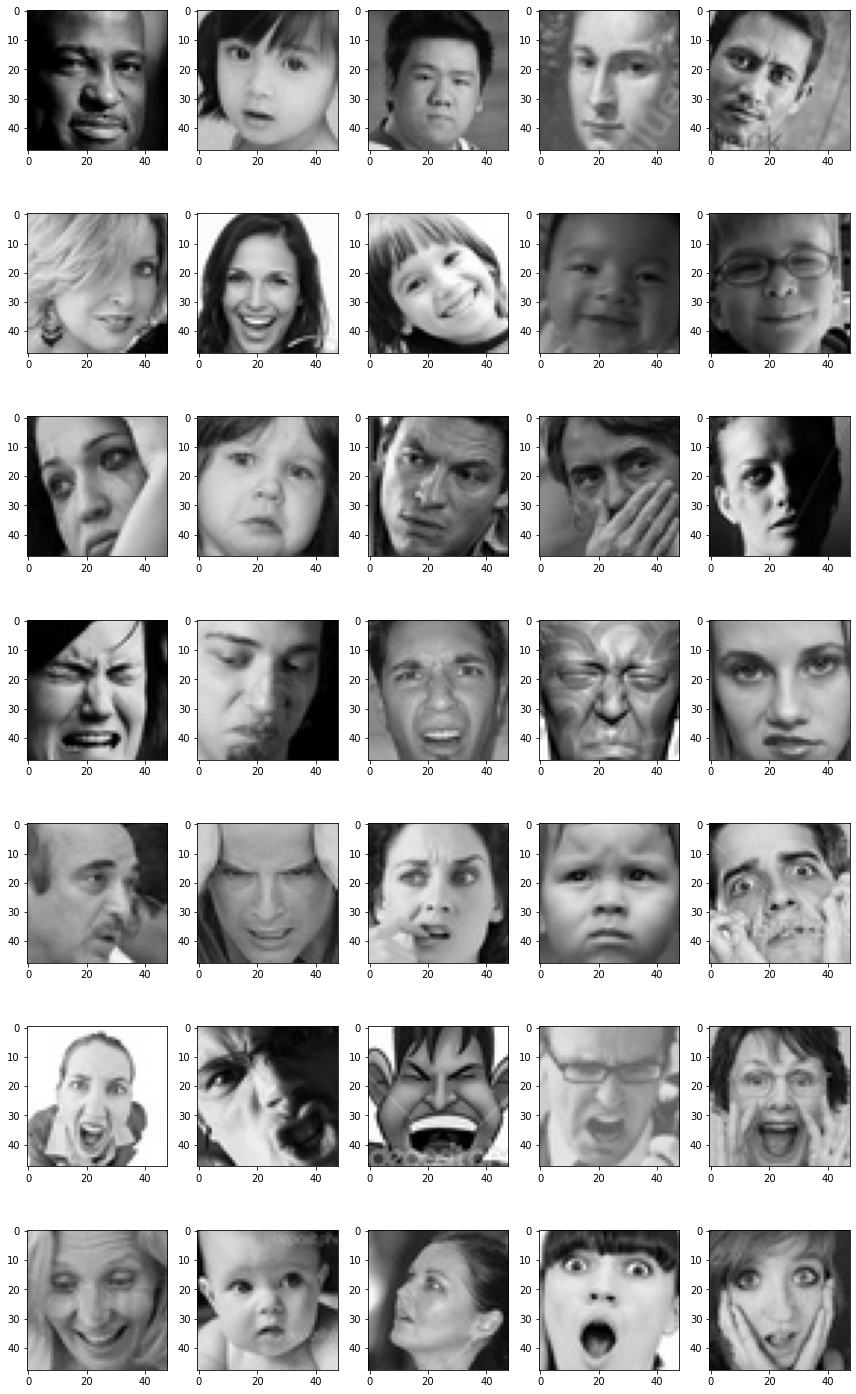

In [4]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "/content/images/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [5]:
# count number of train images for each expression

for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

4982 neutral images
7164 happy images
4938 sad images
436 disgust images
4103 fear images
3993 angry images
3205 surprise images


### Set up Datagenerators

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### Setup our Convolutional Neural Network (CNN)

In [7]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [9]:
# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.9609 - accuracy: 0.2491
Epoch 1: val_accuracy improved from -inf to 0.31463, saving model to model_weights.h5
225/225 [==============================] - 13s 58ms/step - loss: 1.9609 - accuracy: 0.2491 - val_loss: 1.7234 - val_accuracy: 0.3146
Epoch 2/50
224/225 [============================>.] - ETA: 0s - loss: 1.8055 - accuracy: 0.3063
Epoch 2: val_accuracy improved from 0.31463 to 0.33949, saving model to model_weights.h5
225/225 [==============================] - 13s 56ms/step - loss: 1.8051 - accuracy: 0.3066 - val_loss: 1.6628 - val_accuracy: 0.3395
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.7036 - accuracy: 0.3467
Epoch 3: val_accuracy improved from 0.33949 to 0.36378, saving model to model_weights.h5
225/225 [==============================] - 13s 56ms/step - loss: 1.7036 - accuracy: 0.3467 - val_loss: 1.6447 - val_accuracy: 0.3638
Epoch 4/50
225/225 [=============================

In [10]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### Analyse Result

In [11]:
# print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

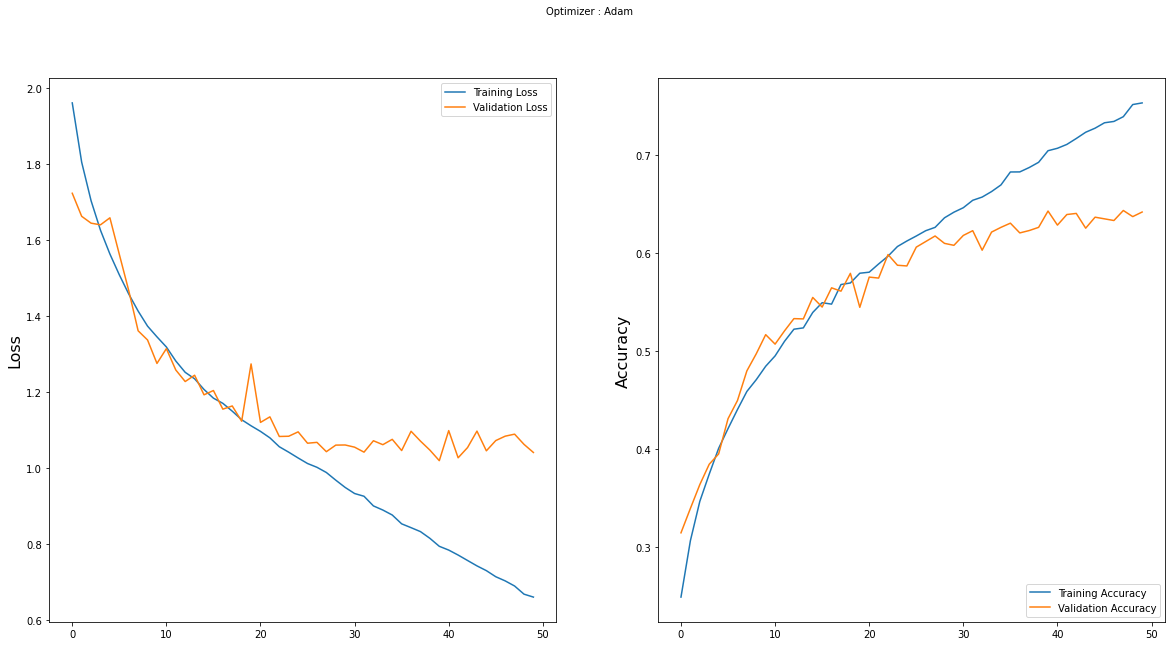

Best Validation Accuracy Score 0.64318, is for epoch 48


In [14]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()
best_epoch =get_best_epcoh(history)

<Figure size 432x288 with 0 Axes>

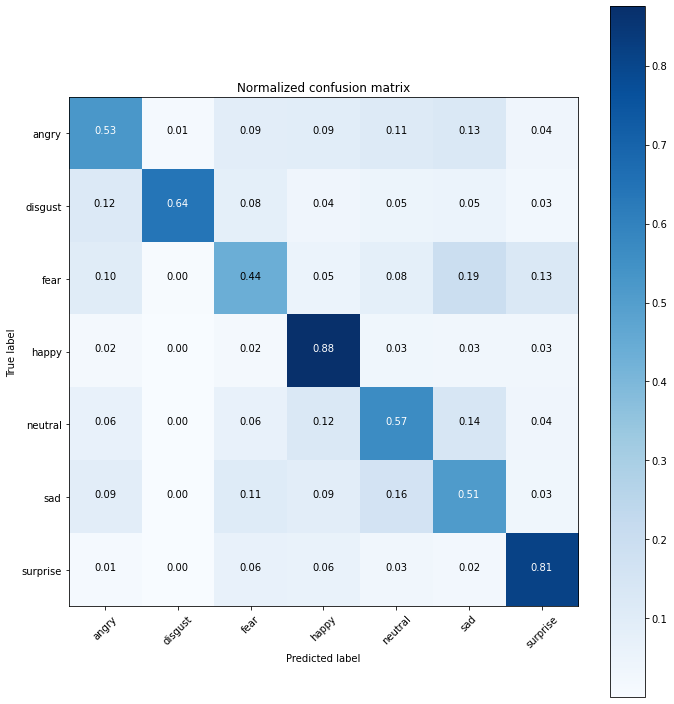

In [15]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict(validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [16]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

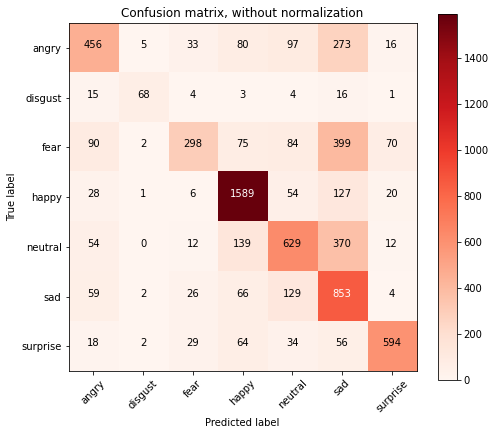

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

### Testing opencv

In [17]:
import numpy as np
import cv2
from tensorflow.keras.models import model_from_json

In [18]:
model_json_file = '/content/model.json'
model_weights_file = '/content/model_weights.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)

In [19]:
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [21]:
cap = cv2.VideoCapture(0)
import copy

while True:
    
    ret, frame = cap.read()
    img = copy.deepcopy(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        fc = gray[y:y+h, x:x+w]
        
        roi = cv2.resize(fc, (48,48))
        pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
        text_idx=np.argmax(pred)
        text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
        if text_idx == 0:
            text= text_list[0]
        if text_idx == 1:
            text= text_list[1]
        elif text_idx == 2:
            text= text_list[2]
        elif text_idx == 3:
            text= text_list[3]
        elif text_idx == 4:
            text= text_list[4]
        elif text_idx == 5:
            text= text_list[5]
        elif text_idx == 6:
            text= text_list[6]
        cv2.putText(img, text, (x, y-5),
           cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
        img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)
            
    
    cv2.imshow("frame", img)
    key = cv2.waitKey(1) & 0xFF
    if key== ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

error: ignored